In [15]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from scripts import process
from scripts import analyse
from scripts import scrp_spc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Import Thailand hospital data
hosp_file = 'hosp'
data_dir = 'data'
output_dir = 'output/clean'

hosp, hosp_raw, dict_path = process.clean(hosp_file, data_dir, output_dir, clear=True)
hosp = hosp[(hosp['status'] != 'ยกเลิก')]
hosp['hcode'] = hosp['hcode'].apply(lambda x: x[2:-1]) #convert hcode from ="xxxxx" to xxxxx
hosp = hosp[hosp['type'].isin(['โรงพยาบาลเอกชน', 'โรงพยาบาล นอก สธ.', 'โรงพยาบาล นอก สป.สธ.', 'โรงพยาบาลชุมชน', 'โรงพยาบาลทั่วไป', 'โรงพยาบาลศูนย์'])].copy()
hosp.to_csv('output/clean/hosp_cleaned.csv')

# Hospital descriptive
hosp_total = len(hosp)
hosp_public = len(hosp[hosp['sector']=='รัฐบาล'])
hosp_private = len(hosp[hosp['sector']=='เอกชน'])

print(
      "----------------------------------------------------",
      "\nTotal hospital:" , hosp_total,
      "\nTotal public hospital:", hosp_public,
      "\nTotal private hospital:", hosp_private,
      "\n----------------------------------------------------")

File name                : hosp
Path to data dictionary  : data/data_dict-hosp.xlsx
Path to cleaned dataset  : output/clean/hosp_cleaned.csv
---------------------------------------------------- 
Total hospital: 1560 
Total public hospital: 1101 
Total private hospital: 459 
----------------------------------------------------


In [22]:
# Import Thailand population data
hosp_file = 'pop'
data_dir = 'data'
output_dir = 'output/clean'

pop, pop_raw, dict_path = process.clean(hosp_file, data_dir, output_dir, clear=True)

pop['prov'] = pop['prov'].apply(lambda x: x if x in ['กรุงเทพมหานคร', 'ทั่วประเทศ'] else x[7:])
pop_country = pop[(pop['prov_id'] == 0)].copy()
pop_prov = pop[(pop['prov_id'] != 0) & (pop['dist_id'] == 0) & (pop['subdist_id'] == 0) & (pop['village_id'] == 0)].copy()
pop_prov.to_csv('output/clean/pop_prov.csv')

pop_dist = pop[pop['subdist_id'] != 0].copy()
pop_dist = pop_dist[['subdist_id', 'pop_male', 'pop_female', 'pop', 'household']]
pop_dist['subdist_id'] = pop_dist['subdist_id'].astype(str)
pop_dist['subdist_id'] = pop_dist['subdist_id'].apply(lambda x: x[:-4])
pop_dist.rename(columns=lambda x: x.replace('subdist_id', 'dist_id') if x.startswith('subdist_id') else x, inplace=True)
pop_dist = pop_dist.groupby('dist_id').sum().reset_index()

pop_hregion = pop_prov.copy()
pop_hregion = process.mapping(pop_hregion, 'prov')
pop_hregion = pop_hregion[['prov', 'pop_female', 'pop_male', 'pop', 'household']].copy()
pop_hregion.rename(columns=lambda x: x.replace('prov', 'hregion') if x.startswith('prov') else x, inplace=True)
pop_hregion = pop_hregion.groupby('hregion').sum().reset_index()
pop_hregion['hregion_id'] = pop_hregion['hregion'].apply(lambda x: x[-2:] if len(x) == 15 else x[-1:])

File name                : pop
Path to data dictionary  : data/data_dict-pop.xlsx
Path to cleaned dataset  : output/clean/pop_cleaned.csv


In [24]:
scrp = input("Would you like to run the scraping process? (Y/N): ").strip().upper()
output_dir = 'output/scraped'

if scrp == 'Y':

    hosp_id = pd.DataFrame({
        'hosp_id': hosp['hcode']
    })

    spc_link = pd.DataFrame({
        'link': ['infopersonal', 'infospecialty', 'infospecialty2', 'infospecialty3', 'infospecialty4', 'infospecialty5']
    })

    spc_path = scrp_spc.scrap(hosp_id, spc_link, output_dir)
    spc_df = pd.read_csv(spc_path)
    
elif scrp == 'N':
    
    # Use previously saved data
    spc_path = os.path.join(output_dir, 'spc.csv')
    
    if os.path.exists(spc_path):
        spc_df = pd.read_csv(spc_path)
        print(f"Data from '{spc_path}' has been successfully loaded and processed.")
    else:
        print(f"Error: The file '{spc_path}' does not exist. Please run the scraping first.")

spc_df['hosp_id'] = spc_df['hosp_id'].apply(lambda x: f'{x:05}')  # Format hospital ID to 5 digits
process.mapping(spc_df, 'spc')
spc_df.to_csv('output/clean/spc_cleaned.csv')

Data from 'output/scraped/spc.csv' has been successfully loaded and processed.


Analyse for overall doctor

In [43]:
# Export data for visualization

df = spc_df.copy()
df = pd.merge(df, hosp[['hcode', 'prov', 'dist_id', 'hregion', 'type']], how='left', left_on='hosp_id', right_on='hcode')
df['dist_id'] = df['dist_id'].astype(int).astype(str)
df['type_gr'] = df['type'].apply(lambda x: 'private' if x == 'โรงพยาบาลเอกชน' else 'public')

df_public = df[df['type_gr'] == 'public']

# Region level
df_hregion = df_public.pivot_table(index=['hregion', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_hregion = pd.merge(df_hregion, pop_hregion[['hregion', 'pop']], how='left', on='hregion')
df_hregion['den'] = df_hregion['total']/(df_hregion['pop']/1000)
df_hregion.to_csv('output/analyse/spc_hregion.csv')

# Province level
df_prov = df_public.pivot_table(index=['prov', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_prov = pd.merge(df_prov, pop_prov[['prov', 'pop']], how='left', on='prov')
df_prov['den'] = df_prov['total']/(df_prov['pop']/1000)
df_prov.to_csv('output/analyse/spc_prov.csv')

# District level
df_dist = df_public.pivot_table(index=['dist_id', 'spc'], values='total', aggfunc='sum', fill_value=0).reset_index()
df_dist = pd.merge(df_dist, pop_dist[['dist_id', 'pop']], how='left', on='dist_id')
df_dist['den'] = df_dist['total']/(df_dist['pop']/1000)
df_dist.to_csv('output/analyse/spc_dist.csv')

In [45]:
n_hosp = len(spc_df['hosp_id'].unique())
n_hosp_public = len(df[df['type_gr'] == 'public']['hosp_id'].unique())
n_hosp_private = len(df[df['type_gr'] == 'private']['hosp_id'].unique())
n_doctor = np.sum(df[df['spc'] == 'Physician']['total'])
n_doctor_public = np.sum(df[(df['spc'] == 'Physician') & (df['type'] != 'โรงพยาบาลเอกชน')]['total'])

print(
    "----------------------------------------------------",
    "\nTotal hospital extracted:", n_hosp,
    "\nNumber of included public hospital:", n_hosp_public,
    "\nNumber of included private hospital:", n_hosp_private,
    "\nNumber of total doctor:", n_doctor,
    "\nNumber of doctor in public hospital:", n_doctor_public,
    "\n----------------------------------------------------")

analyse.describe(df[df['spc'] == 'Physician'], factors=['total'], group_var='type_gr', overall=True, bootstrap=False, table_name='Table 1')

# Ratio calculation
pop_total = pop_country['pop'][0]
den_doctor = n_doctor_public/(pop_total/1000)
den_doctor_hregion = analyse.show_median(df_hregion[df_hregion['spc'] == 'Physician'], 'den')
den_doctor_prov = analyse.show_median(df_prov[df_prov['spc'] == 'Physician'], 'den')
den_doctor_dist = analyse.show_median(df_dist[df_dist['spc'] == 'Physician'], 'den')

print(
    "----------------------------------------------------",
    "\nDoctor per 1000 population in Thailand:", f"{den_doctor:.2f}",
    "\nMedian doctor per 1000 population in health region level:", den_doctor_hregion,
    "\nMedian doctor per 1000 population in province level:", den_doctor_prov,
    "\nMedian doctor per 1000 population in district level:", den_doctor_dist,
    "\n----------------------------------------------------")

---------------------------------------------------- 
Total hospital extracted: 1471 
Number of included public hospital: 1087 
Number of included private hospital: 384 
Number of total doctor: 40737.0 
Number of doctor in public hospital: 31551.0 
----------------------------------------------------
Table 1
Testing for total using Mann-Whitney U
Characteristics    Total         private       public          p-value
-----------------  ------------  ------------  ------------  ---------
total              11.00         12.00         11.00              0.35
                   (5.00-24.00)  (4.00-29.00)  (6.00-22.00)
---------------------------------------------------- 
Doctor per 1000 population in Thailand: 0.48 
Median doctor per 1000 population in health region level: 0.44 (0.39 - 0.47) 
Median doctor per 1000 population in province level: 0.37 (0.32 - 0.45) 
Median doctor per 1000 population in district level: 0.24 (0.17 - 0.36) 
----------------------------------------------------


In [50]:
# Create blank dataframe
result_coverage = pd.DataFrame()
result_ineq = pd.DataFrame()

for spc in sorted(df_public['spc'].unique()):
    row = {}
    row['spc'] = spc

    row['cov_hregion'] = analyse.coverage(df_hregion[df_hregion['spc'] == spc], 'total', 'hregion')
    row['cov_prov'] = analyse.coverage(df_prov[df_prov['spc'] == spc], 'total', 'prov')
    row['cov_dist'] = analyse.coverage(df_dist[df_dist['spc'] == spc], 'total', 'dist')

    result_coverage = pd.concat([result_coverage, pd.DataFrame([row])], ignore_index=True)

result_coverage.to_csv('output/analyse/result_coverage.csv')
display("Coverage analysis", result_coverage)

for spc in sorted(df_public['spc'].unique()):

    row = {}
    row['spc'] = spc

    row['n_spc'] = np.sum(df_prov[df_prov['spc'] == spc]['total'])
    row['T'] = analyse.theil_T(df_prov[df_prov['spc'] == spc], h_column='total', pop_column='pop')
    row['G'] = analyse.gini(df_prov[df_prov['spc'] == spc], h_column='total', pop_column='pop')

    result_ineq = pd.concat([result_ineq, pd.DataFrame([row])], ignore_index=True)

result_ineq.to_csv('output/analyse/result_ineq.csv')
display("Inequity analysis", result_ineq)

'Coverage analysis'

,spc,cov_hregion,cov_prov,cov_dist
0,Anesthesiology,13 (100.00%),77 (100.00%),207 (22.31%)
1,Emergency Medicine,13 (100.00%),75 (97.40%),177 (19.07%)
2,Family Medicine,13 (100.00%),77 (100.00%),505 (54.42%)
3,General Practitioner,13 (100.00%),76 (98.70%),766 (82.54%)
4,Gynecology,13 (100.00%),77 (100.00%),313 (33.73%)
5,Internal Medicine,13 (100.00%),77 (100.00%),364 (39.22%)
6,Neurosurgery,13 (100.00%),68 (88.31%),98 (10.56%)
7,Ophthalmology,13 (100.00%),77 (100.00%),171 (18.43%)
8,Orthopedic,13 (100.00%),77 (100.00%),244 (26.29%)
9,Otolaryngology,13 (100.00%),76 (98.70%),166 (17.89%)


'Inequity analysis'

,spc,n_spc,T,G
0,Anesthesiology,1271.0,0.296322,0.400705
1,Emergency Medicine,784.0,0.145877,0.293862
2,Family Medicine,1694.0,0.090628,0.235963
3,General Practitioner,5050.0,0.061611,0.193751
4,Gynecology,1778.0,0.155840,0.292748
5,Internal Medicine,4811.0,0.242576,0.369157
6,Neurosurgery,370.0,0.313397,0.421452
7,Ophthalmology,969.0,0.255087,0.377417
8,Orthopedic,1522.0,0.136665,0.287002
9,Otolaryngology,764.0,0.199564,0.343206


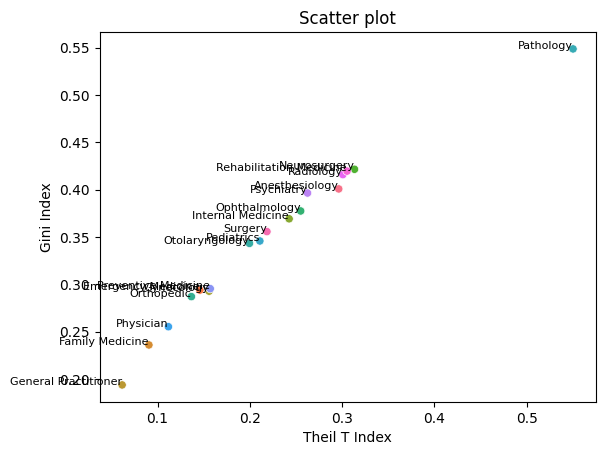

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
sns.scatterplot(x='T', y='G', hue='spc', data=result_ineq, color='blue')

for i, row in result_ineq.iterrows():
    plt.text(row['T'], row['G'], row['spc'], fontsize=8, ha='right')

# Set labels and title
plt.xlabel('Theil T Index')
plt.ylabel('Gini Index')
plt.title(f'Scatter plot')

# Remove legend
plt.legend().set_visible(False)

# Show the plot
plt.show()

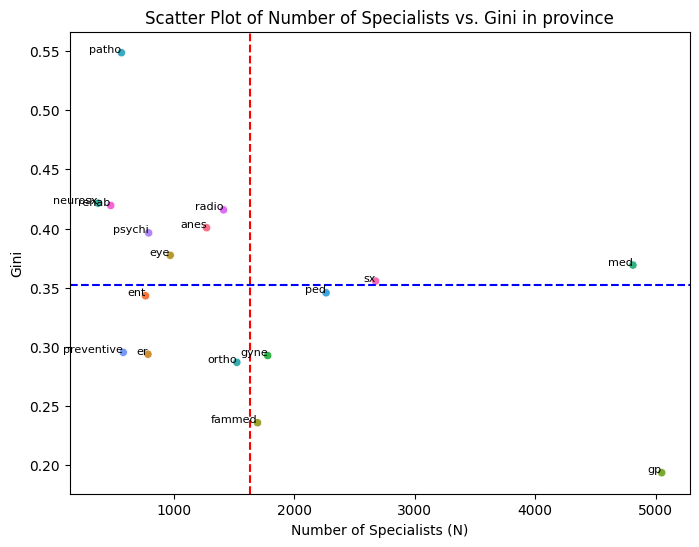

In [156]:
plt.figure(figsize=(8, 6))  # Adjust the figsize to a smaller value

# Scatter plot
sns.scatterplot(x='n_spc', y='G', hue='spc', data=result_ineq, color='blue')

for i, row in result_ineq.iterrows():
    plt.text(row['n_spc'], row['G'], row['spc'], fontsize=8, ha='right')

plt.axvline(np.mean(result_ineq['n_spc']), color='red', linestyle='--')
plt.axhline(np.mean(result_ineq['G']), color='blue', linestyle='--')

plt.title(f'Scatter Plot of Number of Specialists vs. Gini in province')
plt.xlabel('Number of Specialists (N)')
plt.ylabel('Gini')
plt.legend().set_visible(False)
plt.show()  